# MedFoes & Degree-Day Summary Figures
MedFoes input data file created by `Parse longrun output` notebook

In [1]:
import sys
import os
import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from mpl_toolkits.basemap import Basemap

import scipy.interpolate
import pandas as pd
import dateutil

import statsmodels.formula.api as smformula

from collections import OrderedDict

from IPython.display import display, HTML
%matplotlib notebook
plt.style.use('seaborn-paper')

### Load temperature & DD functions from another file

In [2]:
%run "Temperature functions.ipynb"

## Load site information
was created by 'Temperature datasets summary.ipynb' from isd_history.txt

In [3]:
siteinfo = pd.read_csv('stations_summary.csv', index_col='CALL')

### Constants

In [4]:
RUNSETS = [
           ['KSFO','-08:00', '1950-01-01','2016-01-01'],#
           ['KFAT','-08:00', '1950-01-01','2016-01-01'],#
           ['KBUR','-08:00', '1973-01-01','2016-01-01'],#
           ['KLAX','-08:00', '1950-01-01','2016-01-01'],#
           ['KRIV','-08:00', '1950-01-01','2016-01-01'],#
           ['KSAN','-08:00', '1950-01-01','2016-01-01'],#
           ['KJAX','-05:00', '1950-01-01','2016-01-01'],#
           ['KIAH','-06:00', '1970-01-01','2016-01-01'],#
           ['KMCO','-05:00', '1973-01-01','2016-01-01'],#
           ['KTPA','-05:00', '1950-01-01','2016-01-01'],#
           ['KMIA','-05:00', '1950-01-01','2016-01-01'],#
          ]

# the way subplots are ordered by default is different from what we want
RUNSET_IDX_2_PLOT_IDX = [0, 2, 4, 6, 8, 10, 3, 5, 7, 9, 11]

DATADIR = '../data/'
DATA_OUT_FILENAME_PAT = '{}_collated_data_out.npz' # fomatted with RUNSET
FIGDIR = '../figs/'

INTERPOLATION_METHOD = 'nearest'

CONTOUR_LEVELS = [0.05]#, 0.95] # None for off
CONTOUR_COLORS = ['w']#, 'k']

# could potentially be read from configuration
TEMPERATURE_FILENAME = 'temperature_file.csv'
STEP_SIZE = 24*7  # Each step is one week
RUNS_PER_STEP = 2500

## for degree-day computation
PLOT_DD = True
# values from Nick's "Ceratitis capitata- Review of Degree Day Models" (2011): USDA Medfly Action Plan values
# Also values used in CDFA regs sec 3406: https://www.cdfa.ca.gov/plant/medfly/docs/regs/3406-TXT-medfly.pdf
# original source appears to be:
#    Tassan, R. L., K. S. Hagen, A. Cheng, T. K. Palmer, G. Feliciano and T. L. Bough. 1982. 
#    Mediterranean fruit fly life cycle estimations for the California eradication program. 
#    CEC/IOBC Symposium Athens November 1982. pp. 564-570
DD_BASE_TEMP = tempF2C(54.3)
GEN_DD = 622*5/9 # generation time in cumulative degree days
NUM_GENS = 3 # number of generations until 'called'

## Functions

In [5]:
def load_temperatures(runset, sitetz):
    ## Load Temperature data
    tfile = os.path.join(DATADIR, 'temperatures', '{}_AT_cleaned_trimmed.csv'.format(runset))
    tempdf = pd.read_csv(tfile, index_col='datetime', parse_dates=True)
    # Convert the times to localtime at the location... Solar time would be better, but this is good enough
    tempdf.index = tempdf.index.tz_localize('UTC').tz_convert(sitetz)
    return tempdf

# tempdf = load_temperatures(RUNSET)

In [6]:
def calculate_DDs(tempdf, dd_base_temp, dd_threshold):
    ## Calculate DD and crossings

    # simple summation of hourly readings method
    sumdd = compute_summation_DD_from_hourly_df(tempdf,
                                        base_temp=DD_BASE_TEMP,
                                        dd_threshold=GEN_DD*NUM_GENS)
    # Single triangle method
    tridd = compute_single_triangle_DD_from_hourly_df(tempdf,
                                        base_temp=DD_BASE_TEMP,
                                        dd_threshold=GEN_DD*NUM_GENS)
    # BM (single sine) method
    bmdd = compute_BM_DD_from_hourly_df(tempdf,
                                        base_temp=DD_BASE_TEMP,
                                        dd_threshold=GEN_DD*NUM_GENS)
    return sumdd, tridd, bmdd

# sumdd, tridd, bmdd = calculate_DDs(tempdf, DD_BASE_TEMP, GEN_DD*NUM_GENS)

In [7]:
def load_medfoes_results(data_filename, sitetz):
    ## Load and parse the MedFoes data (compute pe95)

    # load the MedFoes data
    tmp = np.load(data_filename)
    runset_name = tmp['runset_name']
    max_run_length = tmp['max_run_length']
    run_hours = np.arange(0,max_run_length,24)
    prop_extinct = tmp['prop_extinct'].item()

    # ...unfortunately surface plots want equally spaced data on X
    runset_starts = [] # just convience
    z = []
    pe95 = [] # storage for the 95% extripation values
    for runset_start in sorted(prop_extinct.keys()):
        pe = prop_extinct[runset_start]
        if len(pe) < 2:
            print("WARNING: too little data for set starting on", runset_start)
            break
        runset_starts.append(runset_start)
        # add a tiny bit to the final ext time so interpolation falls within
        pe[-2,0] = pe[-2,0]+np.spacing(pe[-2,0]) # add epsilon
        # iterpolate
        prop_ex_interp = scipy.interpolate.interp1d(pe[:,0], 
                                                    pe[:,1], 
                                                    kind=INTERPOLATION_METHOD, 
                                                    fill_value=(0,1), #np.nan, 
                                                    bounds_error=False)(run_hours)
        z.append([])
        z[-1] = prop_ex_interp
        # go ahead and compute 95% extirpation values too
        pe95.append(scipy.interpolate.interp1d(pe[:,1], pe[:,0], kind='linear')(0.95).item())

    z = (1-np.array(z)) # proportion persisting

    # make a nice dataframe
    ppdf = pd.DataFrame(data=z, index=runset_starts, columns=run_hours/24)

    # convert the timezone of the index to local for the site
    ppdf.index = ppdf.index.tz_localize('UTC').tz_convert(sitetz)

    # make pe95 a Series
    pe95 = pd.Series(data=pe95, index=ppdf.index)

    return ppdf, pe95

#ppdf, pe95 = load_medfoes_results(DATA_OUT_FILENAME_PAT.format(RUNSET), sitetz)

# Site locations figure
just uses values from 'station_summary.csv' file generated by `Temperature datasets summary.ipynb`

<IPython.core.display.Javascript object>


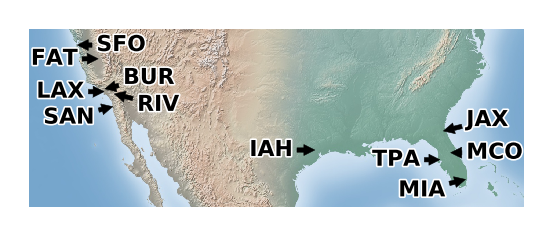

/home/travc/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/travc/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [8]:
fig = plt.figure(figsize=[3.5,1.5])
ax = fig.add_subplot(1,1,1)

# make the Basemap object which handles all the projection stuff for us
m = Basemap(width=5000000,height=1800000,
            resolution='c',projection='aea',
            lon_0=-99.4,lat_0=33)

# m.drawcoastlines(zorder=3)
m.shadedrelief()

for k,v in siteinfo.iterrows():
    x,y = m(float(v['LON']), float(v['LAT']))
    if k in ['KSFO','KMCO']:
        txy = (20,0)
    elif k in ['KBUR','KJAX']:
        txy = (20,5)
    elif k in ['KRIV']:
        txy = (20,-5)
    elif k in ['KSAN','KMIA']:
        txy = (-20,-5)
    else:
        txy = (-20,0)
    a = ax.annotate(k[1:], xy=(x,y), xycoords='data',
                xytext=txy, textcoords='offset points',
                arrowprops=dict(color='k', arrowstyle='simple', shrinkA=0, shrinkB=0),
                ha='center', va='center',
                fontweight='bold',
                fontsize=10,
               )
    a.set_path_effects([patheffects.Stroke(linewidth=1.5, foreground='white'),
                        patheffects.Normal()])

fig.patch.set_alpha(0)
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
plt.axis('off')
fig.tight_layout()
fig.savefig(os.path.join(FIGDIR,'sitemap.pdf'), transparent=True, bbox_inches='tight', pad_inches=0)

# Loading temperature, MED-FOES results, and computing Degree-Day for each site

In [9]:
%%time

# RUNSET = '1950/KRIV'
# LOCAL_TIME_OFFSET = '-08:00' # in the form like "-08:00"

dat = OrderedDict()

for RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE in RUNSETS:
    
    ## Make a timezone...
    # convert from UTC to a *fixed offset* approximating local
    # Note: not just the local timezone, because daylight-savings time is a pointless complication
    # convert the LOCAL_TIME_OFFSET string to number of seconds
    tmp = LOCAL_TIME_OFFSET.split(':')
    tmp = int(tmp[0])*3600+int(tmp[1])*60
    # create a timezone offset
    sitetz = dateutil.tz.tzoffset(LOCAL_TIME_OFFSET, tmp)

    tempdf = load_temperatures(RUNSET, sitetz)

    sumdd, tridd, bmdd = calculate_DDs(tempdf, DD_BASE_TEMP, GEN_DD*NUM_GENS)
    
    mfdatafn = os.path.join(DATADIR, 'MedFoes', 'runsets', DATA_OUT_FILENAME_PAT.format(RUNSET))
    ppdf, pe95 = load_medfoes_results(mfdatafn, sitetz)
    
    dat[RUNSET] = {'sitetz':sitetz,
               'tempdf':tempdf,
               'sumdd':sumdd,
#                'tridd':tridd,
               'bmdd':bmdd,
#                'ppdf':ppdf,
               'pe95':pe95,
              }

CPU times: user 2min 44s, sys: 2.08 s, total: 2min 46s
Wall time: 2min 44s


# Main figure for the paper showing values of normals

<IPython.core.display.Javascript object>


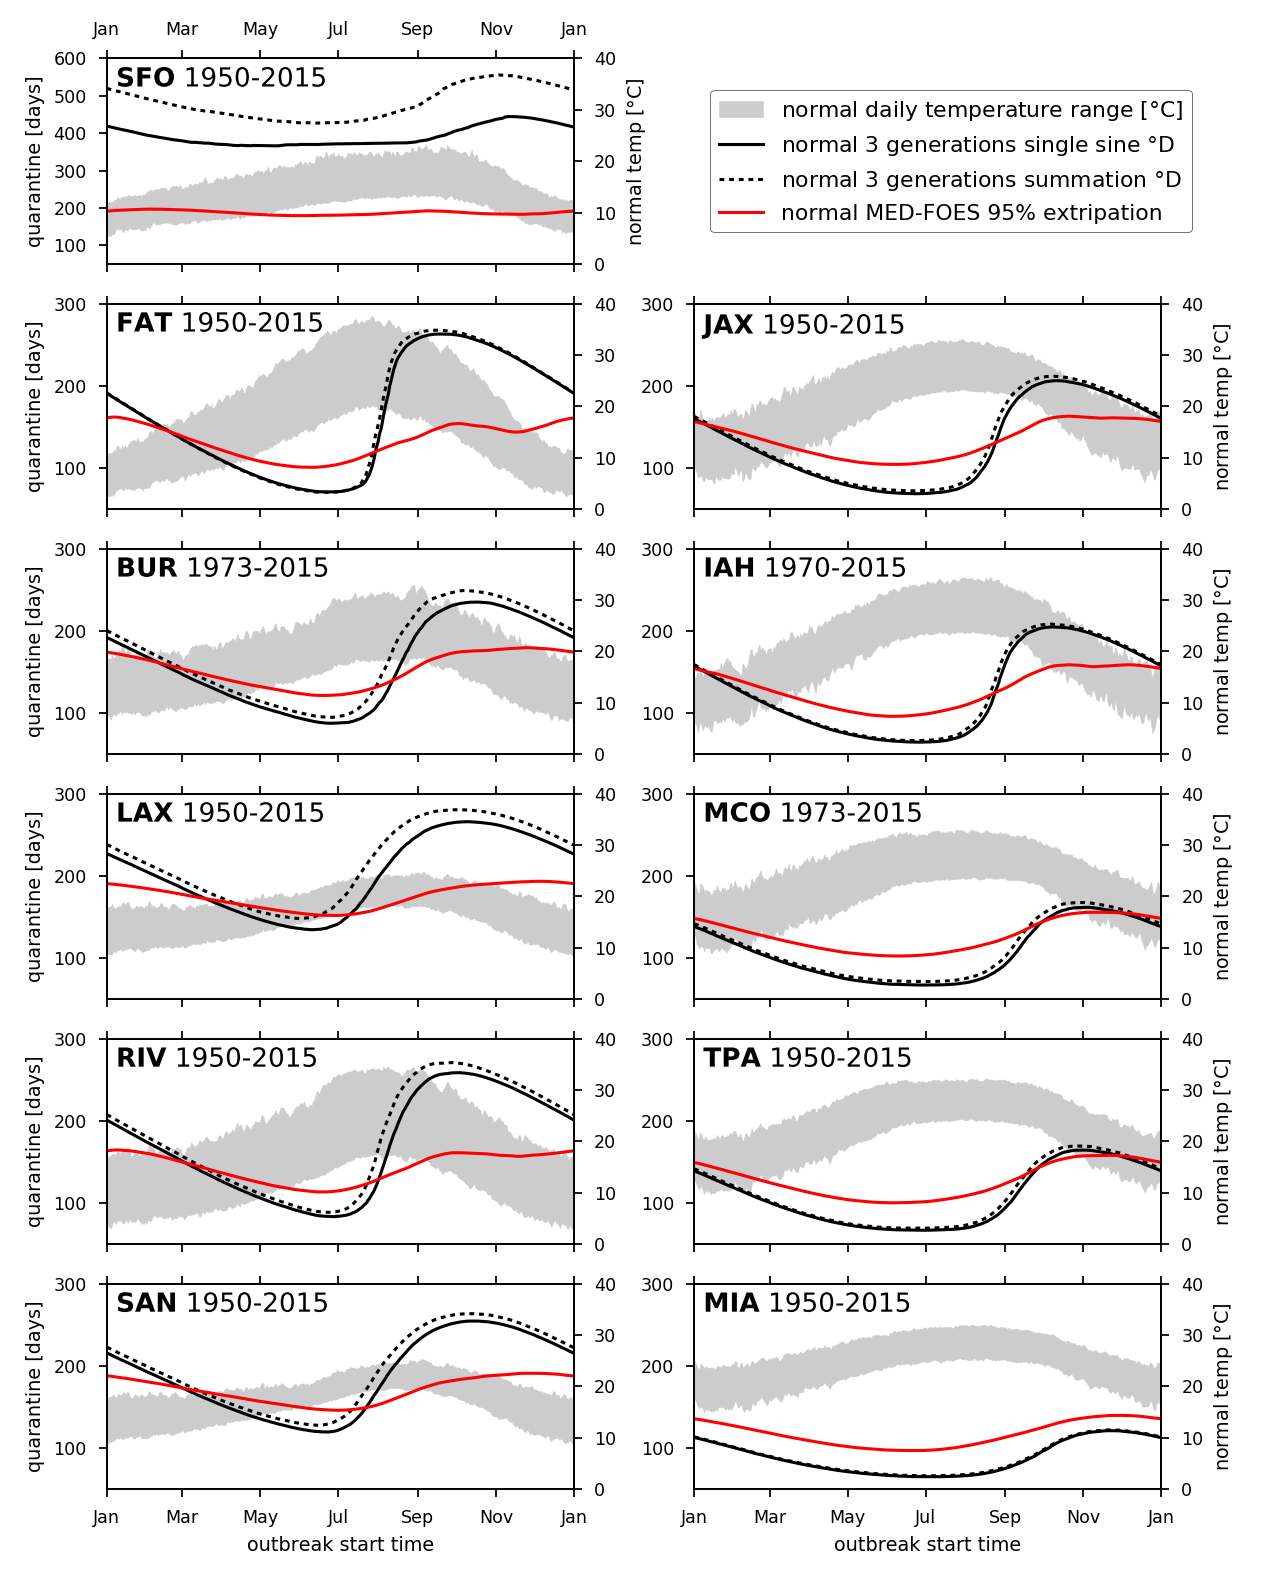

KSFO 1950-01-01 2016-01-01
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
KFAT 1950-01-01 2016-01-01
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
KBUR 1973-01-01 2016-01-01
Computing using range: 1973-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1973-01-01 00:00:00-08:00 to 2016-01-0

In [10]:
fig = plt.figure(figsize=[8,10])
plotrows = 6
plotcols = 2
gs = mpl.gridspec.GridSpec(plotrows, plotcols)

for runseti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    ploti = RUNSET_IDX_2_PLOT_IDX[runseti]

    sitetz = dat[RUNSET]['sitetz']
    tempdf = dat[RUNSET]['tempdf']
    sumdd = dat[RUNSET]['sumdd']
    # tridd = dat[RUNSET]['tridd'] # not used for this plot
    bmdd = dat[RUNSET]['bmdd']
    # ppdf = dat[RUNSET]['ppdf'] # not used for this plot
    pe95 = dat[RUNSET]['pe95']

    print(RUNSET, START_DATE, END_DATE) # just informative/progress output

    # normal of degree-day crossings
    sumdd_norm, sumdd_resamp = compute_year_over_year_norm(sumdd['dur_days'],
                                         START_DATE, END_DATE,
                                         norm_start=START_DATE,
                                         norm_end=END_DATE,
                                         freq='daily',
                                         interp_method=None)
    bmdd_norm, bmdd_resamp = compute_year_over_year_norm(bmdd['dur_days'],
                                         START_DATE, END_DATE,
                                         norm_start=START_DATE,
                                         norm_end=END_DATE,
                                         freq='daily',
                                         interp_method=None)

    # normal of MedFoes 95% extirpation
    pe95_norm, pe95_resamp = compute_year_over_year_norm(pe95,
                                       START_DATE, END_DATE,
                                       norm_start=START_DATE,
                                       norm_end=END_DATE,
                                       freq='daily',
                                       interp_method='linear')


    ax2 = fig.add_subplot(gs[int(ploti/plotcols), int(ploti%plotcols)])
    ax = ax2.twinx()
    # put ax in front of ax2 
    ax2.set_zorder(ax.get_zorder()+1)
    ax.patch.set_visible(True)
    ax2.patch.set_visible(False)

    # use an arbitarary single year range of the normals (it is just repeated)
    r1 = '2010-01-01'
    r2 = '2011-01-01'

    ## Temperature
    # compute normals of the daily min and max tempeatures
    maxtempnorm, maxtempresamp = compute_year_over_year_norm(tempdf['AT'].groupby(pd.TimeGrouper('D')).max(),
                                                       START_DATE, END_DATE,
                                                       norm_start=START_DATE,
                                                       norm_end=END_DATE,
                                                       freq='daily',
                                                       interp_method=None)
    mintempnorm, mintempresamp = compute_year_over_year_norm(tempdf['AT'].groupby(pd.TimeGrouper('D')).min(),
                                                       START_DATE, END_DATE,
                                                       norm_start=START_DATE,
                                                       norm_end=END_DATE,
                                                       freq='daily',
                                                       interp_method=None)
    x = maxtempnorm.loc[r1:r2]
    x2 = mintempnorm.loc[r1:r2]
    ax.fill_between(x.index, x2.values, x.values,
                   label=r'normal daily temperature range [$\degree$C]',
                   color='#CCCCCC')
    # # normal daily mean temperature
    # tempnorm, tempresamp = compute_year_over_year_norm(tempdf['AT'].groupby(pd.TimeGrouper('D')).mean(),
    #                                                    START_DATE, END_DATE,
    #                                                    norm_end=END_DATE,
    #                                                    freq='daily',
    #                                                    interp_method=None)
    # x = tempnorm.loc[r1:r2]
    # ax.plot(x.index, x, color='gray', ls='-')
    
    y2 = bmdd_norm.loc[r1:r2]
    ax2.plot(y2.index, y2, label=r'normal 3 generations single sine $\degree$D', color='k')
    y2 = sumdd_norm.loc[r1:r2]
    ax2.plot(y2.index, y2, label=r'normal 3 generations summation $\degree$D', color='k', ls=':')
    
    y = pe95_norm.loc[r1:r2]/24.0
    ax2.plot(y.index, y, label=r'normal MED-FOES 95% extripation', color='r')

    plt.autoscale(enable=True, tight=True)
    
    ax2.tick_params(axis='x', top=True, bottom=True)
    if ploti == 0:
        ax2.tick_params(axis='x', labeltop=True, labelbottom=False)

    
    if ploti%plotcols == 1 or ploti <= 1:
        ax.set_ylabel('normal temp [$\degree$C]')
    if ploti%plotcols == 0 or ploti <= 1:
        ax2.set_ylabel('quarantine [days]')
    ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
    if ploti > 9:
         ax2.set_xlabel('outbreak start time')
    if ploti > 1 and ploti < 10:
        ax.set_xticklabels([])

    # Title / plot label
#     ax.set_title(RUNSET[-4:]+' {} to {}'.format(
#         pd.to_datetime(START_DATE).strftime('%Y-%m'),
#         pd.to_datetime(END_DATE).strftime('%Y-%m')
#     ))
    tmp = r'$\bf '+RUNSET[-3:]+r'$'+' {}-{}'.format(
                        pd.to_datetime(START_DATE).strftime('%Y'),
                        int(pd.to_datetime(END_DATE).strftime('%Y'))-1)
    txt = ax.text(.02, .96, tmp, transform=ax.transAxes,
                  ha='left', va='top', fontsize='large')
    txt.set_path_effects([patheffects.Stroke(linewidth=1.5, foreground='white'),
                          patheffects.Normal()])

    # HARDCODED LIMITS (so all plots are comparable)
    ax.set_ylim([0,40])
    ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
    if RUNSET == 'KSFO': # KSFO needs its own scale
        ax2.set_ylim([50,600])        
    else:
        ax2.set_ylim([50,300])

# legend
legax = fig.add_subplot(gs[0,1])
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
leg = legax.legend(h1+h2, l1+l2, loc='center', fontsize=10,
                   bbox_to_anchor=(.55, .5))
legax.set_frame_on(False)
leg.get_frame().set_facecolor('white')
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_alpha(1)
legax.get_yaxis().set_visible(False)
legax.get_xaxis().set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, 'fig_main.pdf'))

# Super norms
Extends the concept of normal (as in normal temperature) 
to include distributional (quantiles, max, min, ect.) info
instead of just the mean for each set of values grouped by day-of-year. 

In [11]:
def compute_super_norm(in_df, 
                       start_date, end_date,
                       date_pad='1 days',
                       freq='24h',
                       quantiles=[0.05, 0.25, 0.5, 0.75, 0.95],
                      ):
    start_date = pd.to_datetime(start_date).tz_localize(in_df.index.tz)
    end_date = pd.to_datetime(end_date).tz_localize(in_df.index.tz)
    date_pad = pd.Timedelta(date_pad)
    
    t = in_df.loc[start_date-date_pad:end_date+date_pad].copy(deep=True)
    
    nidx = pd.date_range(start_date, end_date, freq=freq)

    t = pd.Series(scipy.interpolate.interp1d(
                                            t.index.astype('int64').values, 
                                            t.values, 
                                            kind='linear',
                                            fill_value=np.nan, #(0,1) 
                                            bounds_error=False)(nidx.astype('int64').values),
                              index=nidx)

#     gb = t.groupby([t.index.month, t.index.day, t.index.hour])
    gb = t.groupby([t.index.month, t.index.day])

    # start with quantiles
    norm = gb.quantile(quantiles).sort_index()
    # unstack to make each quantile value a column
    norm = norm.to_frame().unstack()
    norm.columns.set_levels(['quantile'], level=0, inplace=True)

    # add the mean and others
    norm['mean'] = gb.mean().sort_index()
    norm['max'] = gb.max().sort_index()
    norm['min'] = gb.min().sort_index()
    norm['std'] = gb.agg(np.std, ddof=0).sort_index()
    norm['skew'] = gb.skew().sort_index()

    norm = norm.drop((2,29,)) # drop leapyear extra day
    
    # Convert the multi-index (month, day, hour) to a datetime index
    # NOTE: year (yr) is abitrary and meaningless beyond being a leapyear or not a leapyear (not is simpler)
    yr = 2011
#     idx = pd.date_range(start='{}-{:02d}-{:02d} {:02d}:00:00'.format(yr,*norm.index[0]),
#                         end=  '{}-{:02d}-{:02d} {:02d}:00:00'.format(yr,*norm.index[-1]),
#                         freq='24h',
#                         tz=t.index.tz)
    idx = pd.date_range(start='{}-{:02d}-{:02d} 00:00:00'.format(yr,*norm.index[0]),
                    end=  '{}-{:02d}-{:02d} 00:00:00'.format(yr,*norm.index[-1]),
                    freq='24h',
                    tz=t.index.tz)
    norm.index = idx
    
    return norm

# Uncertainty in quarantine length
The idea is to simply show how much predicted quarantine length varies
to give an indication of uncertainty in quarantine length for management decisions

<IPython.core.display.Javascript object>


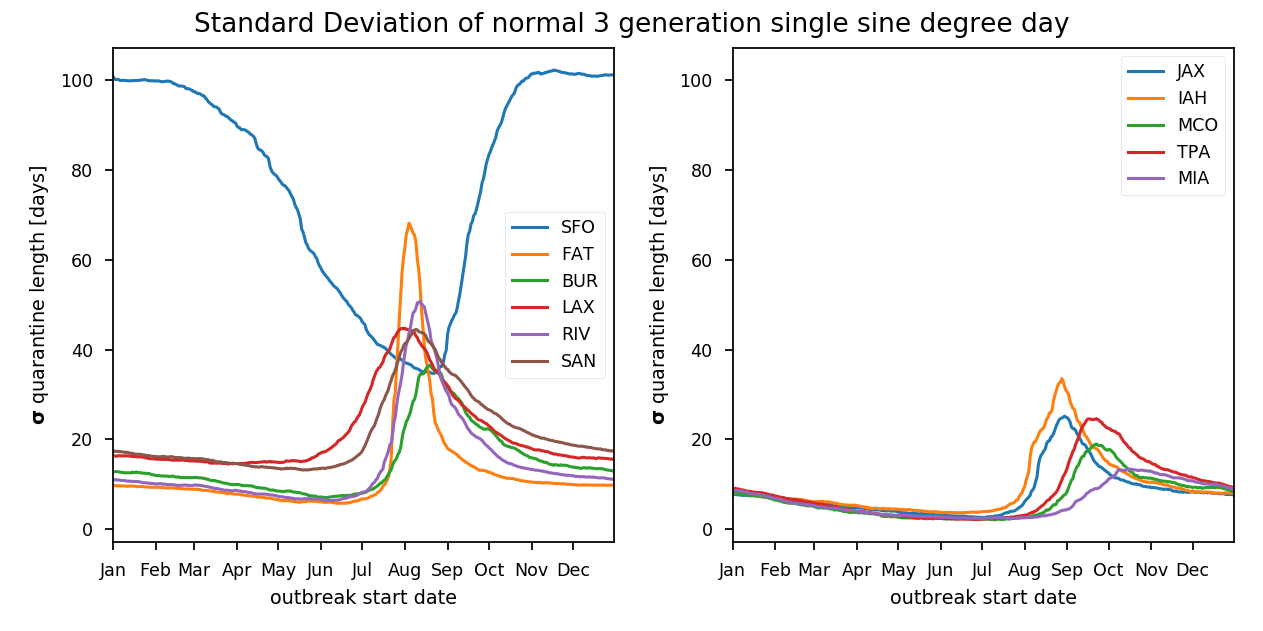

KSFO 1950-01-01 2016-01-01
KFAT 1950-01-01 2016-01-01
KBUR 1973-01-01 2016-01-01
KLAX 1950-01-01 2016-01-01
KRIV 1950-01-01 2016-01-01
KSAN 1950-01-01 2016-01-01
KJAX 1950-01-01 2016-01-01
KIAH 1970-01-01 2016-01-01
KMCO 1973-01-01 2016-01-01
KTPA 1950-01-01 2016-01-01
KMIA 1950-01-01 2016-01-01


In [12]:
fig = plt.figure(figsize=[8,4])
plotrows = 1
plotcols = 2
gs = mpl.gridspec.GridSpec(plotrows, plotcols)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1], sharey=ax1)
    
for ploti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    print(RUNSET, START_DATE, END_DATE)

    norm = compute_super_norm(dat[RUNSET]['bmdd']['dur_days'], START_DATE, END_DATE)
        
#     if ploti==0 or ploti%2 == 1:
    if ploti < 6:
        ax = ax1
    else:
        ax = ax2
        
    ax.plot(norm.index, norm['std'], label=RUNSET[-3:])
    ax.set_ylabel(r'$\bf\sigma$ quarantine length [days]')
    
for ax in [ax1,ax2]:
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
    ax.set_xlabel('outbreak start date')
    ax.legend()

fig.suptitle('Standard Deviation of normal 3 generation single sine degree day')

# fig.tight_layout doesn't work with suptitle... so have to use gridspec and tweak by hand
gs.tight_layout(fig, rect=[0, 0, 1, 0.97])

plt.savefig(os.path.join(FIGDIR, 'fig_BMDD_variation.pdf'))

<IPython.core.display.Javascript object>


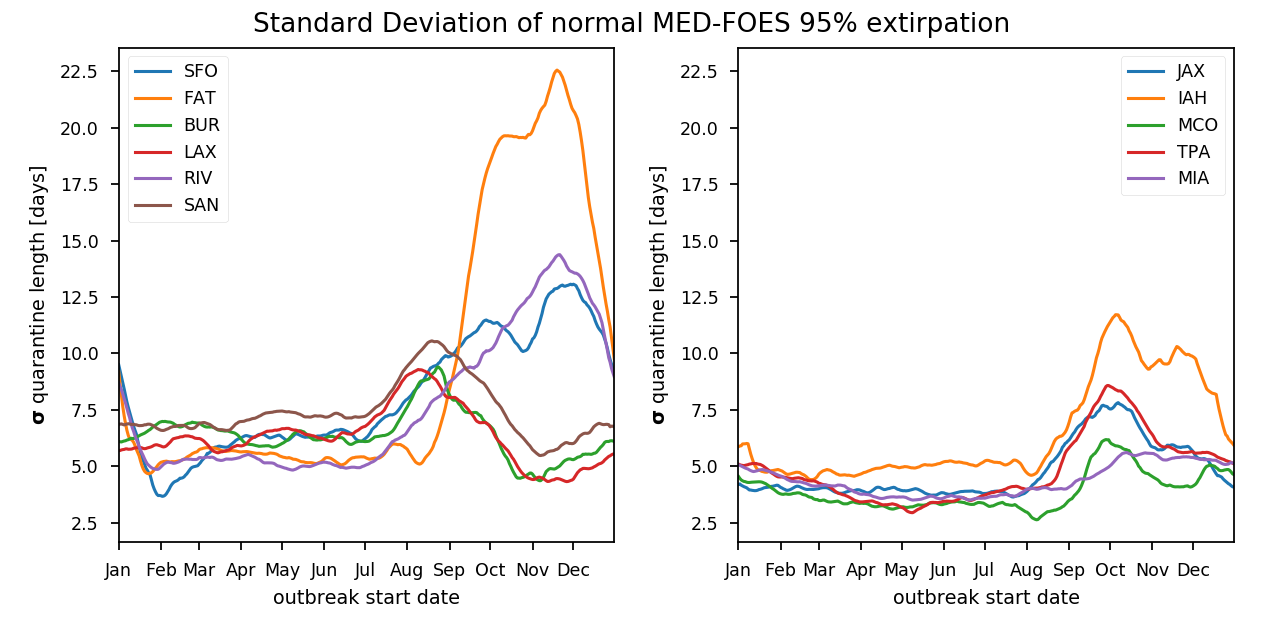

KSFO 1950-01-01 2016-01-01
KFAT 1950-01-01 2016-01-01
KBUR 1973-01-01 2016-01-01
KLAX 1950-01-01 2016-01-01
KRIV 1950-01-01 2016-01-01
KSAN 1950-01-01 2016-01-01
KJAX 1950-01-01 2016-01-01
KIAH 1970-01-01 2016-01-01
KMCO 1973-01-01 2016-01-01
KTPA 1950-01-01 2016-01-01
KMIA 1950-01-01 2016-01-01


In [13]:
fig = plt.figure(figsize=[8,4])
plotrows = 1
plotcols = 2
gs = mpl.gridspec.GridSpec(plotrows, plotcols)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1], sharey=ax1)
    
for ploti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    print(RUNSET, START_DATE, END_DATE)

    norm = compute_super_norm(dat[RUNSET]['pe95']/24, START_DATE, END_DATE)
        
    if ploti < 6:
        ax = ax1
    else:
        ax = ax2
        
    ax.plot(norm.index, norm['std'], label=RUNSET[-3:])
    ax.set_ylabel(r'$\bf\sigma$ quarantine length [days]')

for ax in [ax1,ax2]:
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
    ax.set_xlabel('outbreak start date')
    ax.legend()

fig.suptitle('Standard Deviation of normal MED-FOES 95% extirpation')

# fig.tight_layout doesn't work with suptitle... so have to use gridspec and tweak by hand
gs.tight_layout(fig, rect=[0, 0, 1, 0.97])

plt.savefig(os.path.join(FIGDIR, 'fig_pe95_variation.pdf'))

## More complete super-norm distribution figures for supplemental

In [14]:
def plot_all_supernorm(datakey,
                       datafunc=None,
                       datafreq='24h',
                       ylim=None,
                       ylim_dict={},
                       xlabel='INDEX',
                       ylabel='VALUE',
                       legend_title=None,
                       subplot_label_pos=(0.02, 0.96),
                       subplot_label_pos_dict={},
                      ):

    fig = plt.figure(figsize=[8,10])
    plotrows = 6
    plotcols = 2
    gs = mpl.gridspec.GridSpec(plotrows, plotcols)

    for runseti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
        ploti = RUNSET_IDX_2_PLOT_IDX[runseti]
        print(RUNSET, START_DATE, END_DATE)

        ########################
        if datafunc is not None:
            norm = compute_super_norm(datafunc(dat[RUNSET][datakey]), START_DATE, END_DATE, freq=datafreq)
        else:
            norm = compute_super_norm(dat[RUNSET][datakey], START_DATE, END_DATE, freq=datafreq)

        ## plot
        ax = fig.add_subplot(gs[int(ploti/plotcols), int(ploti%plotcols)])

        ax.fill_between(norm.index, norm[('quantile',0.25)].values, norm[('quantile',0.75)].values,
                       label='0.25 to 0.75 quantile range',
                       color='#AAAAAA')

        ax.plot(norm.index, norm[('quantile',0.5)], 'k-', lw=.75, label='median')
        ax.plot(norm.index, norm['mean'], 'r-', lw=.75, label='mean')

        ax.plot(norm.index, norm['min'], ls=':', color='k', lw=.75, label='')
        ax.plot(norm.index, norm['max'], ls=':', color='k', lw=.75, label='minimum & maximum')

    #     ax.plot(norm.index, norm[('quantile',0.05)], ls='-', color='gray', lw=.75, label='')
    #     ax.plot(norm.index, norm[('quantile',0.95)], ls='-', color='gray', lw=.75, label='0.05 & 0.95 quantiles')

        ax.autoscale(enable=True, tight=True)
        # potentially hardcoded limits for y (so all plots are comparable)
        if ylim is not None:
            ax.set_ylim(ylim)
        # individually set ylims (from ylim_dict) get highlighted to indicated they aren't the same as the rest
        if ploti in ylim_dict:
            ax.set_ylim(ylim_dict[ploti])
#             for tmp in ax.get_yticklabels():
#                 tmp.set_fontweight('bold')
            ax.yaxis.set_tick_params(labelcolor='firebrick')

        # ticks and labels (only on certain plots)
        ax.tick_params(axis='x', top=True, bottom=True)
        if ploti == 0:
            ax.tick_params(axis='x', labeltop=True, labelbottom=False) 
        if ploti%plotcols == 0 or ploti <= 1:
            ax.set_ylabel(ylabel)
        ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
        if ploti > 9:
             ax.set_xlabel(xlabel)
        if ploti > 1 and ploti < 10:
            ax.set_xticklabels([])

        # labels for each subplot
        tmp = r'$\bf '+RUNSET[-3:]+r'$'+' {}-{}'.format(
                            pd.to_datetime(START_DATE).strftime('%Y'),
                            int(pd.to_datetime(END_DATE).strftime('%Y'))-1)
        tx,ty = subplot_label_pos
        if ploti in subplot_label_pos_dict:
            tx,ty = subplot_label_pos_dict[ploti]
        txt = ax.text(tx, ty, tmp, transform=ax.transAxes,
                      ha='left', va='top', fontsize='large')
        txt.set_path_effects([patheffects.Stroke(linewidth=1.5, foreground='white'),
                              patheffects.Normal()])

    # legend
    legax = fig.add_subplot(gs[0,1])
    h1, l1 = ax.get_legend_handles_labels()
    leg = legax.legend(h1, l1, loc='center', 
                       fontsize=10,
                       bbox_to_anchor=(.5, .5),
                       title=legend_title)
    leg.get_title().set_fontweight('bold')
    leg.get_title().set_fontsize('large')
    legax.set_frame_on(False)
    leg.get_frame().set_facecolor('white')
    leg.get_frame().set_edgecolor('k')
    leg.get_frame().set_alpha(1)
    legax.get_yaxis().set_visible(False)
    legax.get_xaxis().set_visible(False)

    plt.tight_layout()
    return fig   

<IPython.core.display.Javascript object>


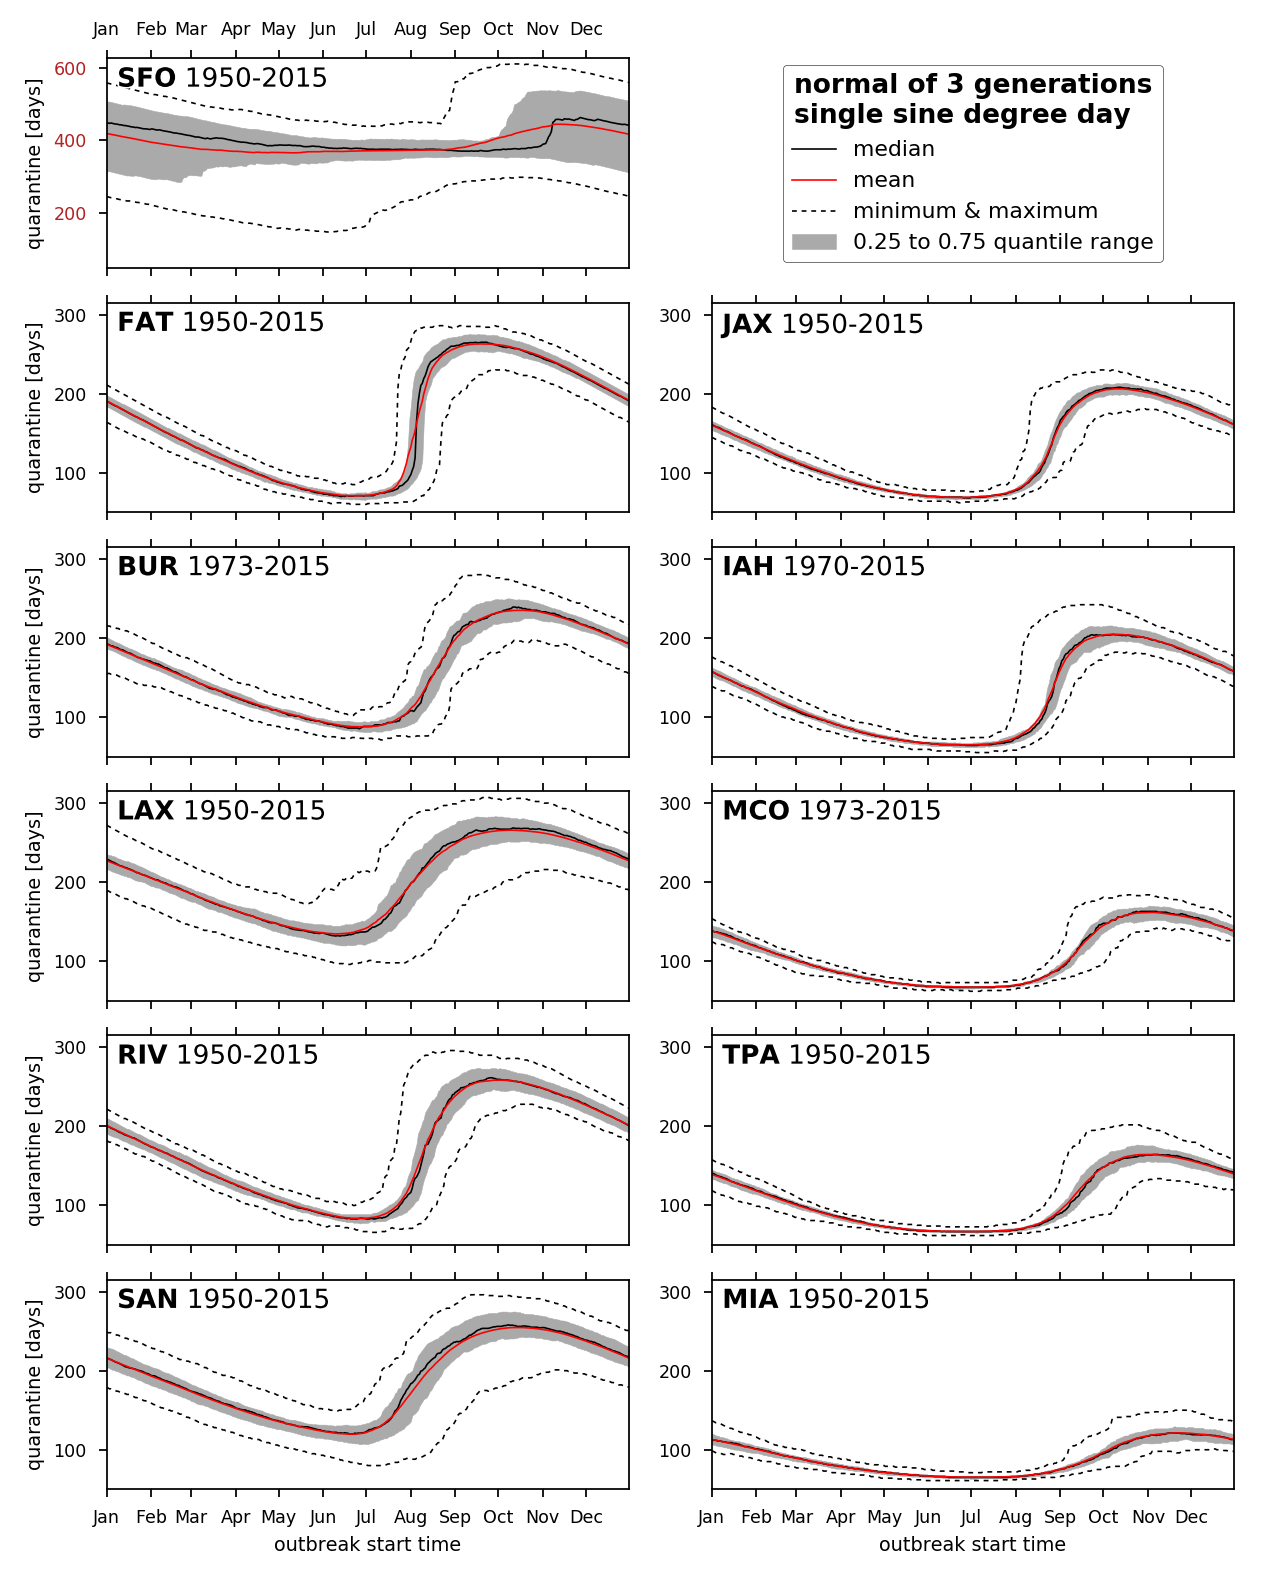

KSFO 1950-01-01 2016-01-01
KFAT 1950-01-01 2016-01-01
KBUR 1973-01-01 2016-01-01
KLAX 1950-01-01 2016-01-01
KRIV 1950-01-01 2016-01-01
KSAN 1950-01-01 2016-01-01
KJAX 1950-01-01 2016-01-01
KIAH 1970-01-01 2016-01-01
KMCO 1973-01-01 2016-01-01
KTPA 1950-01-01 2016-01-01
KMIA 1950-01-01 2016-01-01


In [15]:
fig = plot_all_supernorm('bmdd',
                         datafunc=lambda x: x['dur_days'],
                         ylim=[50,315],
                         ylim_dict={0:(50,625)},
                         xlabel='outbreak start time',
                         ylabel='quarantine [days]',
                         legend_title='normal of 3 generations\nsingle sine degree day',
                        )
fig.savefig(os.path.join(FIGDIR, 'fig_all_BMDD_supernorm.pdf'))

<IPython.core.display.Javascript object>


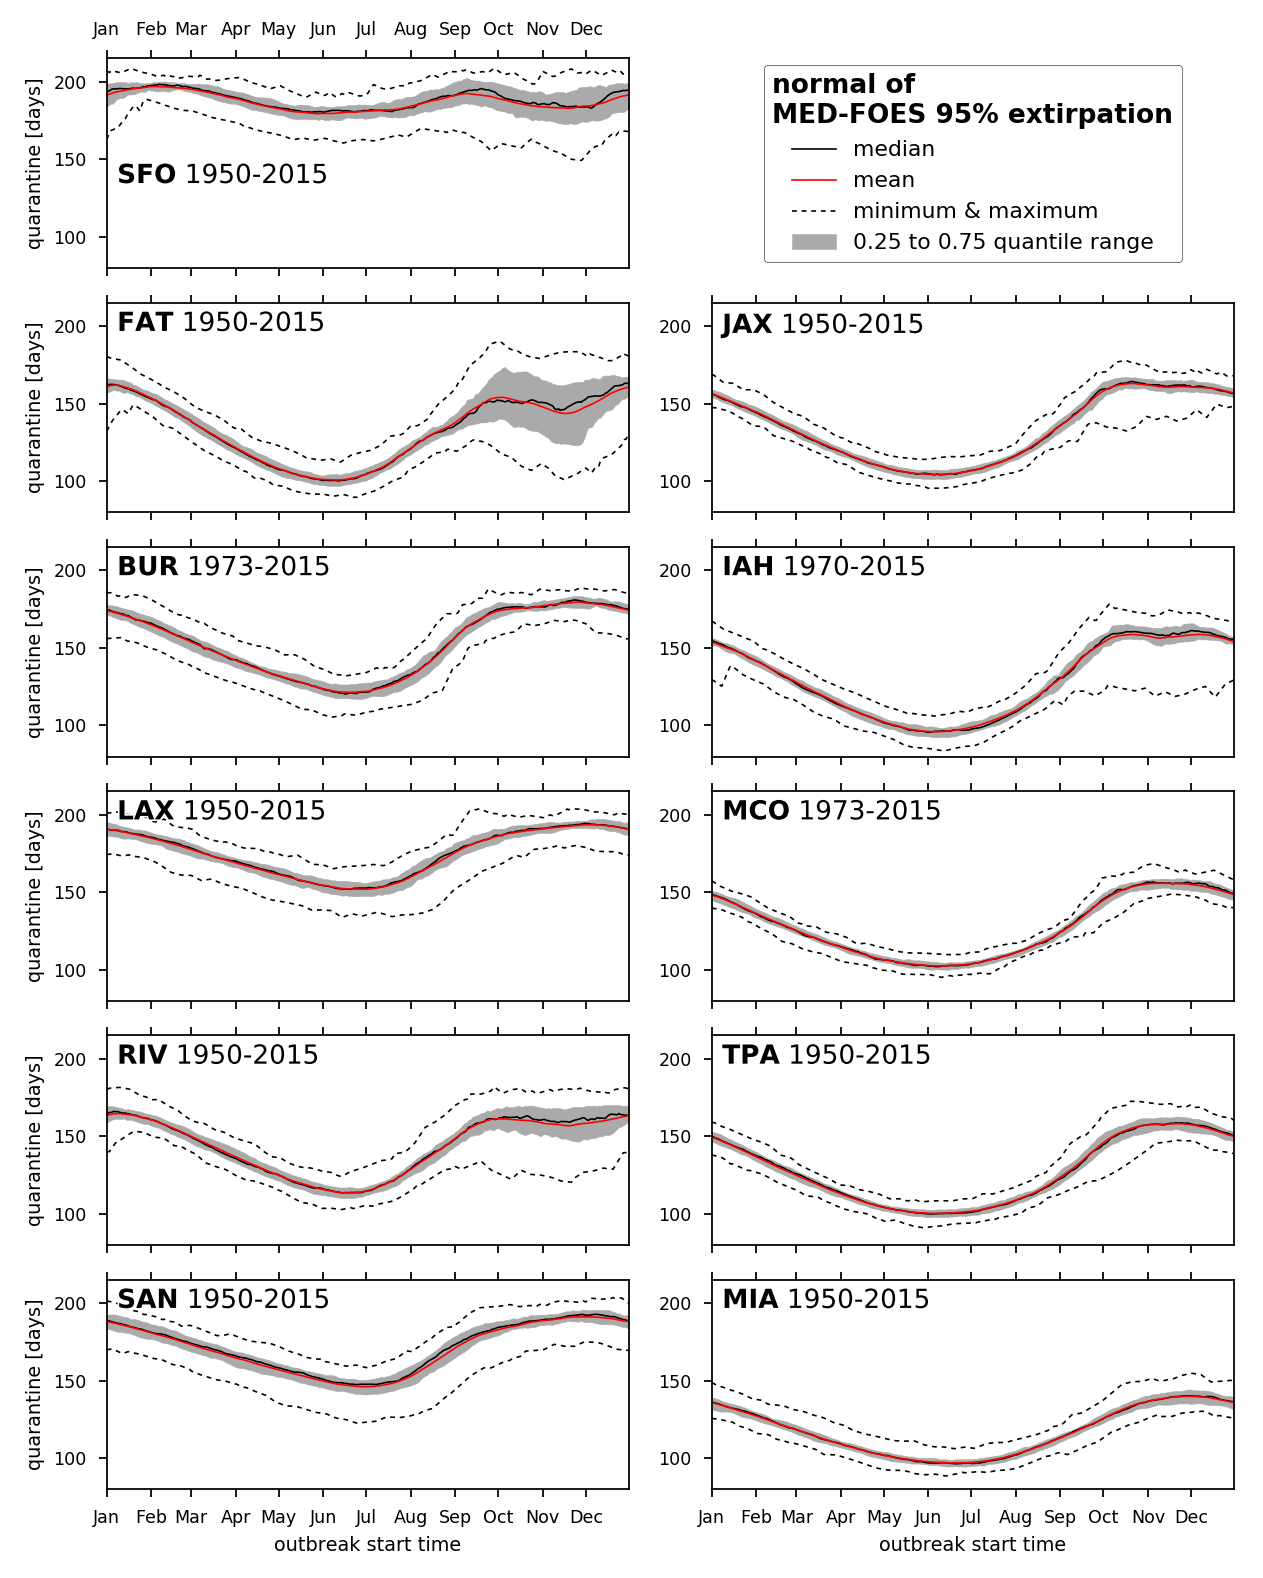

KSFO 1950-01-01 2016-01-01
KFAT 1950-01-01 2016-01-01
KBUR 1973-01-01 2016-01-01
KLAX 1950-01-01 2016-01-01
KRIV 1950-01-01 2016-01-01
KSAN 1950-01-01 2016-01-01
KJAX 1950-01-01 2016-01-01
KIAH 1970-01-01 2016-01-01
KMCO 1973-01-01 2016-01-01
KTPA 1950-01-01 2016-01-01
KMIA 1950-01-01 2016-01-01


In [16]:
fig = plot_all_supernorm('pe95',
                         datafunc=lambda x: x/24.0,
                         ylim=[80,215],
                         xlabel='outbreak start time',
                         ylabel='quarantine [days]',
                         legend_title='normal of\nMED-FOES 95% extirpation',
                         subplot_label_pos_dict={0:(0.02, 0.5)},
                        )
fig.savefig(os.path.join(FIGDIR, 'fig_all_pe95_supernorm.pdf'))

<IPython.core.display.Javascript object>


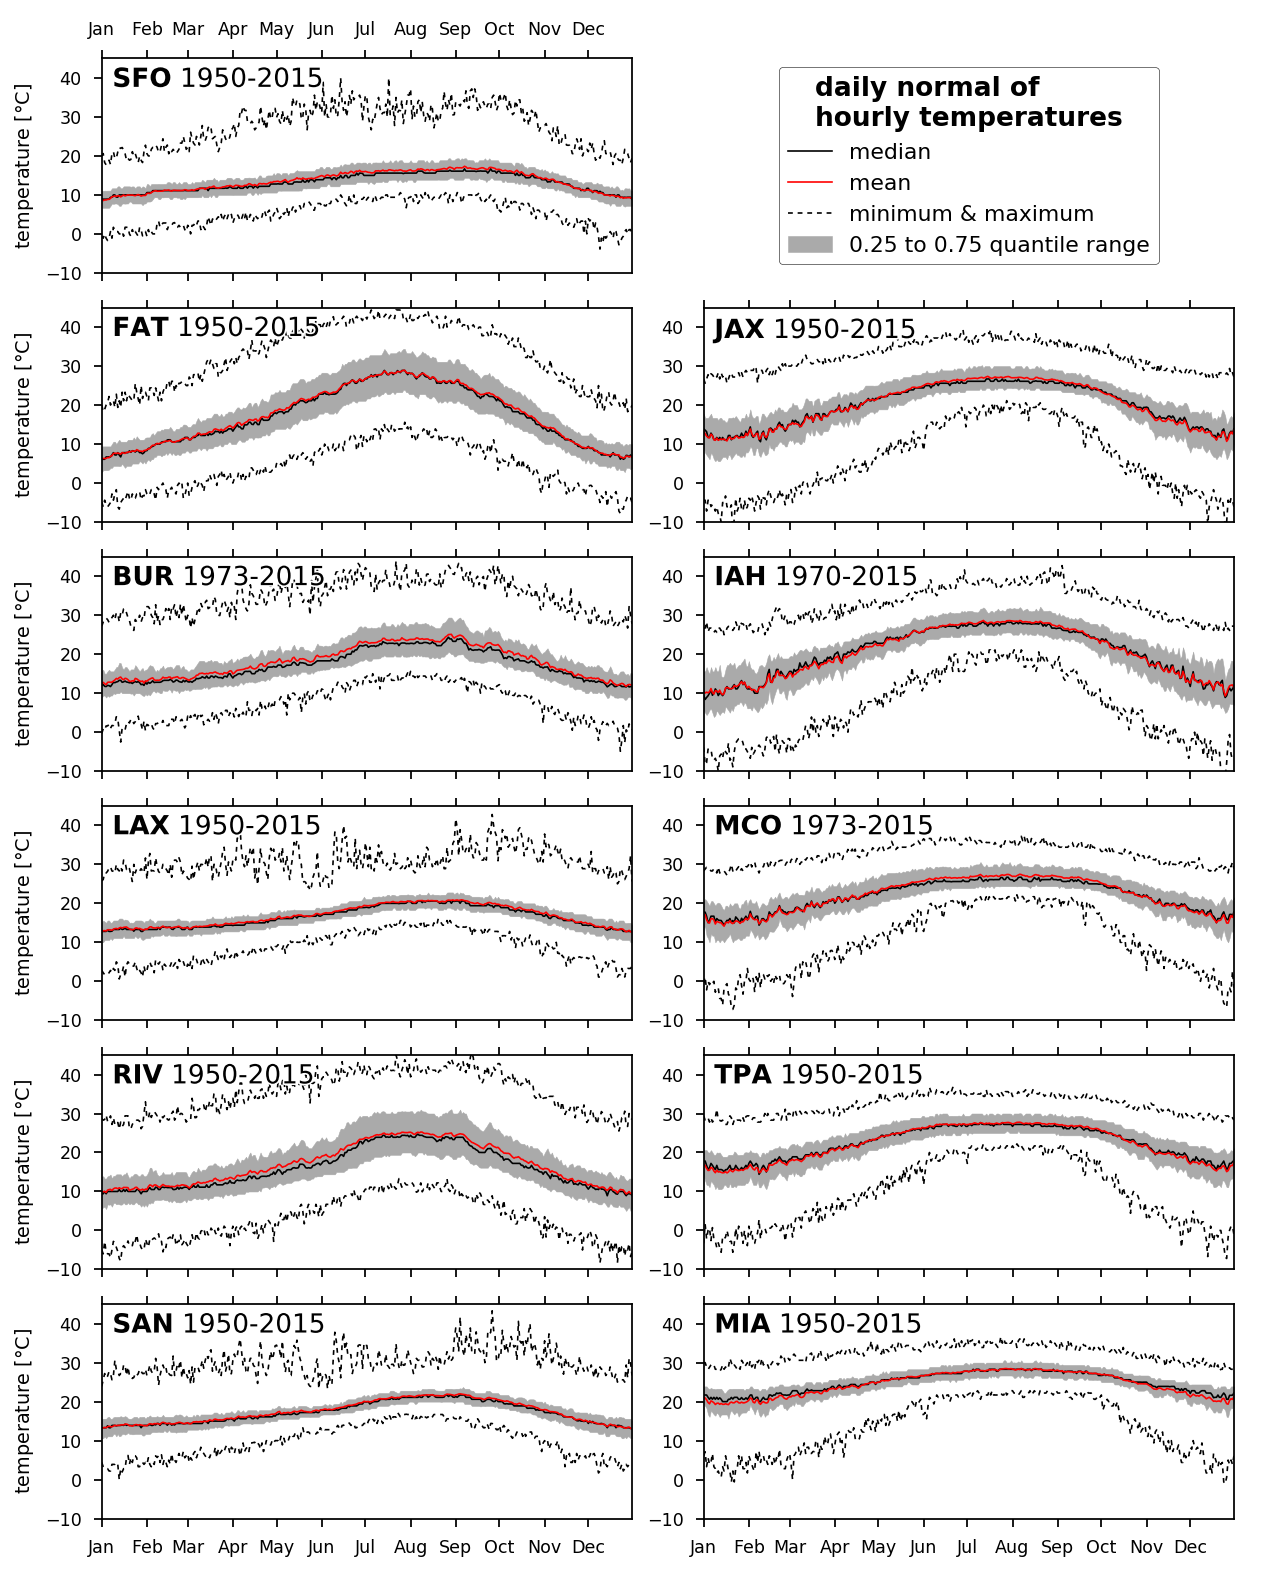

KSFO 1950-01-01 2016-01-01
KFAT 1950-01-01 2016-01-01
KBUR 1973-01-01 2016-01-01
KLAX 1950-01-01 2016-01-01
KRIV 1950-01-01 2016-01-01
KSAN 1950-01-01 2016-01-01
KJAX 1950-01-01 2016-01-01
KIAH 1970-01-01 2016-01-01
KMCO 1973-01-01 2016-01-01
KTPA 1950-01-01 2016-01-01
KMIA 1950-01-01 2016-01-01


In [17]:
fig = plot_all_supernorm('tempdf',
                         datafunc=lambda x: x['AT'],
                         datafreq='1h',
                         ylim=[-10,45],
                         xlabel='',
                         ylabel='temperature [$\degree$C]',
                         legend_title='daily normal of\nhourly temperatures',
                        )
fig.savefig(os.path.join(FIGDIR, 'fig_all_hourly_temps_supernorm.pdf'))

# Amount of variance captured by normal ($R^2$)

In [39]:
vardf = pd.DataFrame(columns=['BMDD_R2', 'BMDD_adjR2', 'BMDD_N', 'BMDD_P',
                              'pe95_R2', 'pe95_adjR2', 'pe95_N', 'pe95_P'])

for ploti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    sitetz = dat[RUNSET]['sitetz']
    tempdf = dat[RUNSET]['tempdf']
    sumdd = dat[RUNSET]['sumdd']['dur_days']
    bmdd = dat[RUNSET]['bmdd']['dur_days']
    pe95 = dat[RUNSET]['pe95']

#     print(RUNSET, START_DATE, END_DATE) # just informative/progress output

    # normal of degree-day crossings
    bmdd_norm, bmdd_resamp = compute_year_over_year_norm(bmdd,
                                         START_DATE, END_DATE,
                                         norm_start=START_DATE,
                                         norm_end=END_DATE,
                                         freq='daily',
                                         interp_method=None,
                                         quiet=True)

    # normal of MedFoes 95% extirpation
    pe95_norm, pe95_resamp = compute_year_over_year_norm(pe95/24.0, # converting from hours to days
                                       START_DATE, END_DATE,
                                       norm_start=START_DATE,
                                       norm_end=END_DATE,
                                       freq='daily',
                                       interp_method='linear',
                                       quiet=True)
    
    idx = bmdd.loc[START_DATE:END_DATE].index
    bmdd_r2 = 1-(bmdd.loc[idx]-bmdd_norm.loc[idx]).var()/bmdd.loc[idx].var()
    bmdd_n = bmdd.loc[idx].count()
    bmdd_p = bmdd_norm.loc['2001-01-01 00:00:00':'2001-12-31 23:59:59'].count()
    bmdd_adjr2 = bmdd_r2-(1-bmdd_r2)*bmdd_p/(bmdd_n-bmdd_p-1)

    # have to round pe95 index to nearest day (midnight) since
    # temperature infile was in localtime instead of fixed-offset and
    # daylight-savings-time causes "off by one hour" problems
    rpe95 = pe95.copy(deep=True)/24.0 # convert from hours to days
    rpe95.index = pe95.index.round('D')

    idx = rpe95.loc[START_DATE:END_DATE].index
    pe95_r2 = 1-(rpe95.loc[idx]-pe95_norm.loc[idx]).var()/rpe95.loc[idx].var()
    pe95_n = rpe95.loc[idx].count()
    pe95_p = pe95.loc['2001-01-01 00:00:00':'2001-12-31 23:59:59'].count()
    pe95_adjr2 = pe95_r2-(1-pe95_r2)*pe95_p/(pe95_n-pe95_p-1)
    
#     print("{}\t{:5.2f}%\t{:5.2f}%".format(RUNSET, 
#             bmdd_var_captured*100, pe95_var_captured*100))
    
    vardf.loc[RUNSET] = {'BMDD_R2': bmdd_r2,
                         'BMDD_adjR2': bmdd_adjr2,
                         'BMDD_N': bmdd_n,
                         'BMDD_P': bmdd_p,
                         'pe95_R2': pe95_r2,
                         'pe95_adjR2': pe95_adjr2,
                         'pe95_N': pe95_n,
                         'pe95_P': pe95_p,
                        }
        
display(vardf)

,BMDD_R2,BMDD_adjR2,BMDD_N,BMDD_P,pe95_R2,pe95_adjR2,pe95_N,pe95_P
KSFO,0.091187,0.077215,24107.0,365.0,0.280143,0.269104,3444.0,52.0
KFAT,0.939310,0.938377,24107.0,365.0,0.756817,0.753088,3444.0,52.0
KBUR,0.907102,0.904891,15706.0,365.0,0.908846,0.906682,2243.0,52.0
KLAX,0.801671,0.798621,24107.0,365.0,0.830676,0.828079,3444.0,52.0
KRIV,0.922344,0.921150,24107.0,365.0,0.818854,0.816076,3444.0,52.0
KSAN,0.809900,0.806977,24107.0,365.0,0.809105,0.806178,3444.0,52.0
KJAX,0.964525,0.963979,24107.0,365.0,0.947845,0.947045,3444.0,52.0
KIAH,0.950957,0.949868,16802.0,365.0,0.918048,0.916232,2400.0,52.0
KMCO,0.946190,0.944910,15706.0,365.0,0.957679,0.956675,2244.0,52.0
KTPA,0.919124,0.917880,24107.0,365.0,0.944016,0.943158,3444.0,52.0


In [40]:
vardf.median()

BMDD_R2           0.919124
BMDD_adjR2        0.917880
BMDD_N        24107.000000
BMDD_P          365.000000
pe95_R2           0.908846
pe95_adjR2        0.906682
pe95_N         3444.000000
pe95_P           52.000000
dtype: float64

# Latitude dependence

<IPython.core.display.Javascript object>


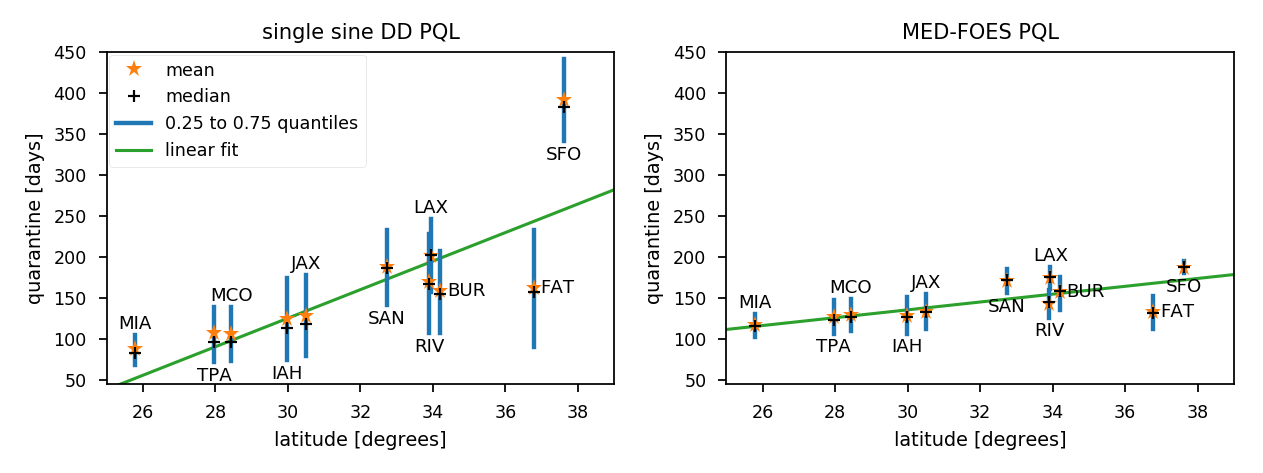

Intercept   -396.245153
lat           17.393655
dtype: float64

/home/travc/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 median   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     14.08
Date:                Mon, 07 Aug 2017   Prob (F-statistic):            0.00454
Time:                        13:48:51   Log-Likelihood:                -58.597
No. Observations:                  11   AIC:                             121.2
Df Residuals:                       9   BIC:                             122.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -396.2452    149.177     -2.656      0.026      -733.707   -58.784
lat           17.3937      4.635      3.753      0.005         6.909    27.879
==============================================================================
Omnibus:                        6.675   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                2.525
Skew:                           0.903   Prob(JB):                        0.283
Kurtosis:                       4.499   Cond. No.                         290.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Intercept   -7.722371
lat          4.780893
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 median   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     10.55
Date:                Mon, 07 Aug 2017   Prob (F-statistic):             0.0100
Time:                        13:48:51   Log-Likelihood:                -45.979
No. Observations:                  11   AIC:                             95.96
Df Residuals:                       9   BIC:                             96.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -7.7224     47.376     -0.163      0.874      -114.894    99.449
lat            4.7809      1.472      3.248      0.010         1.451     8.111
==============================================================================
Omnibus:                        2.411   Durbin-Watson:                   2.697
Prob(Omnibus):                  0.300   Jarque-Bera (JB):                0.625
Skew:                          -0.554   Prob(JB):                        0.732
Kurtosis:                       3.367   Cond. No.                         290.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
SKIP_SFO = False

fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
legh = None

bmdd_stats_df = pd.DataFrame(columns=['N','lat','mean','median', 'q25', 'q75'])
pe95_stats_df = pd.DataFrame(columns=['N','lat','mean','median', 'q25', 'q75'])

for runseti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    if SKIP_SFO and RUNSET == 'KSFO': continue
    bmdd = dat[RUNSET]['bmdd']['dur_days']
    pe95 = (dat[RUNSET]['pe95']/24.0)
    lat = siteinfo.loc[RUNSET]['LAT']

    for i,(d,ax) in enumerate([[bmdd,ax1], [pe95,ax2]]):
        # min to max
#         ax.plot([lat,lat], [d.min(),d.max()], ls='-', lw=.75, color='k',
#                 label='min to max')
        # quantiles (0.25, 0.75)
        ax.plot([lat,lat], [d.quantile(0.25),d.quantile(0.75)], ls='-', lw=2, color='C0',
                label='0.25 to 0.75 quantiles')
        # mean and median points
        ax.plot(lat, d.median(), marker='+', ls='none', mew=1, mec='k', mfc='none', label='median', zorder=3)
        ax.plot(lat, d.mean(), marker='*', ms=8, ls='none', color='C1', label='mean')
        
        df = bmdd_stats_df
        if i == 1:
            df = pe95_stats_df
            
        df.loc[RUNSET] = {'N': d.count(), 
                          'lat': lat, 
                          'mean': d.mean(),
                          'median': d.median(),
                          'q25': d.quantile(0.25),
                          'q75': d.quantile(0.75),
                         }

        if legh is None:
            legh, legl = ax.get_legend_handles_labels()

# labeling the sites
for runseti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    if SKIP_SFO and RUNSET == 'KSFO': continue
    for i,(df,ax) in enumerate([[bmdd_stats_df,ax1], [pe95_stats_df,ax2]]):
        lat = df.loc[RUNSET,'lat']
        if RUNSET in ['KTPA',
                      'KIAH',
                      'KSAN',
                      'KRIV',
                      'KSFO',
                     ]:
            ty = df.loc[RUNSET,'q25']
            ax.annotate(RUNSET[1:], xy=[lat, ty],
                         xytext=[0,-2],
                         textcoords='offset points',
                         va='top', ha='center',
                         fontsize='small')
        elif RUNSET in ['KBUR',
                        'KFAT']:
            ty = df.loc[RUNSET,'mean']
            ax.annotate(RUNSET[1:], xy=[lat, ty],
                         xytext=[3,0],
                         textcoords='offset points',
                         va='center', ha='left',
                         fontsize='small')
        else:
            ty = df.loc[RUNSET,'q75']
            ax.annotate(RUNSET[1:], xy=[lat, ty],
                         xytext=[0,1],
                         textcoords='offset points',
                         va='bottom', ha='center',
                         fontsize='small')
            
## OLS fit
MODEL_FORMULA = 'median ~ lat'
EXCLUDE_SITES = []
if SKIP_SFO:
    EXCLUDE_SITES = ['KSFO']
for i,(df,ax) in enumerate([[bmdd_stats_df,ax1], [pe95_stats_df,ax2]]):
    r = smformula.ols(formula=MODEL_FORMULA, 
                           data=df[~df.index.isin(EXCLUDE_SITES)]).fit()
    display(r.params)
    display(r.summary())
    
    xrng = np.array([25,39])
    p, = ax.plot(xrng, (xrng*r.params.lat)+r.params.Intercept, 
                color='C2', zorder=1)
    if i == 0:
        legh.insert(0, p)
        legl.insert(0, 'linear fit')

ax1.autoscale(enable=True, axis='x', tight=True)
ax1.set_ylabel('quarantine [days]')
ax1.set_xlabel('latitude [degrees]')
ax1.set_title('single sine DD PQL')

ax2.autoscale(enable=True, axis='x', tight=True)
ax2.set_ylabel('quarantine [days]')
ax2.set_xlabel('latitude [degrees]')
ax2.set_title('MED-FOES PQL')

if SKIP_SFO:
    ax1.set_ylim([55,265])
    ax2.set_ylim([55,265])
else:
    ax1.set_ylim([45,450])
    ax2.set_ylim([45,450])

ax1.legend(legh[::-1], legl[::-1], frameon=True, borderaxespad=0.15)

fig.tight_layout()

if SKIP_SFO:
    fig.savefig(os.path.join(FIGDIR, 'fig_latitude_trend_excludeSFO.pdf'))
else:
    fig.savefig(os.path.join(FIGDIR, 'fig_latitude_trend_withSFO.pdf'))

In [21]:
bmdd_stats_df

,N,lat,mean,median,q25,q75
KSFO,24275.0,37.620,391.206797,383.0,341.0,441.0
KFAT,24358.0,36.780,162.594548,157.0,90.0,233.0
KBUR,15984.0,34.201,158.600976,155.0,107.0,207.0
KLAX,24372.0,33.938,201.844206,202.0,157.0,246.0
KRIV,24365.0,33.900,169.303796,167.0,107.0,228.0
KSAN,24389.0,32.734,187.838083,187.0,141.0,233.0
KJAX,24446.0,30.495,128.493864,119.0,79.0,178.0
KIAH,17177.0,29.980,125.079117,114.0,74.0,175.0
KMCO,16095.0,28.434,106.234421,97.0,73.0,139.0
KTPA,24513.0,27.962,106.877086,97.0,72.0,139.0


In [22]:
pe95_stats_df

,N,lat,mean,median,q25,q75
KSFO,3496.0,37.620,187.211192,187.791667,180.218750,195.671875
KFAT,3496.0,36.780,132.992451,131.697917,112.666667,152.083333
KBUR,3496.0,34.201,156.939079,158.687500,135.833333,176.000000
KLAX,3496.0,33.938,174.347337,176.062500,160.958333,188.250000
KRIV,3496.0,33.900,143.375244,145.125000,125.802083,160.083333
KSAN,3496.0,32.734,170.274963,171.576389,156.041667,185.333333
KJAX,3496.0,30.495,133.627332,132.868750,112.458333,154.833333
KIAH,2491.0,29.980,128.479338,127.375000,106.208333,151.645833
KMCO,3382.0,28.434,129.498362,126.625000,110.216146,148.911458
KTPA,3496.0,27.962,126.823681,123.614583,106.704861,147.298611


# Difference between degree day and MED-FOES PQL

In [23]:
# add a difference between bmdd and pe95 to the dat for each runset 
# so we can generate the supernorm and some stats

df = pd.DataFrame(columns=['lat', 'mean', '%days>0'])

for runseti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    sitetz = dat[RUNSET]['sitetz']
    tempdf = dat[RUNSET]['tempdf']
    bmdd = dat[RUNSET]['bmdd']
    pe95 = dat[RUNSET]['pe95']
    # have to round pe95 index to nearest day (midnight) since
    # temperature infile was in localtime instead of fixed-offset and
    # daylight-savings-time causes "off by one hour" problems
    rpe95 = pe95.copy(deep=True)/24.0 # convert from hours to days
    rpe95.index = pe95.index.round('D')
    # should also round pe95 up to whole days to make it fairly comparable to BMDD
    rpe95 = rpe95.apply(np.ceil)
    
    # using just the days we have run MED-FOES simulations for (every 7 days)
    tmp = bmdd['dur_days'].loc[rpe95.index]-rpe95
    tmp = tmp.loc[START_DATE:END_DATE]

    dat[RUNSET]['bmdd-pe95'] = tmp
    
    # also generate some statistics in tabular form
    df.loc[RUNSET] = [np.nan]*len(df.columns) # add a blank row for the key
    df.loc[RUNSET]['lat'] = siteinfo.loc[RUNSET]['LAT']
    df.loc[RUNSET]['mean'] = tmp.mean()
    df.loc[RUNSET]['%days>0'] = (tmp>0).sum()/tmp.shape[0]*100
    
#     # nicely formatted output
#     if runseti == 0:
#         print('Site','mean differene', 'days BMDD > pe95', sep='\t')
#     print("{}\t{:6.2f}\t{:5.2f}%".format(RUNSET[1:], 
#                       df.loc[RUNSET]['mean'], 
#                       df.loc[RUNSET]['%days>0']), 
#           sep='\t')

display(df)

,lat,mean,%days>0
KSFO,37.62,204.295,99.5354
KFAT,36.78,29.6208,53.5134
KBUR,34.201,5.99064,48.5956
KLAX,33.938,27.2741,67.8281
KRIV,33.9,25.7334,56.7073
KSAN,32.734,17.3293,58.4495
KJAX,30.495,-5.49448,36.324
KIAH,29.98,-3.69583,35.3333
KMCO,28.434,-21.2955,13.2353
KTPA,27.962,-20.3278,14.0534


<IPython.core.display.Javascript object>


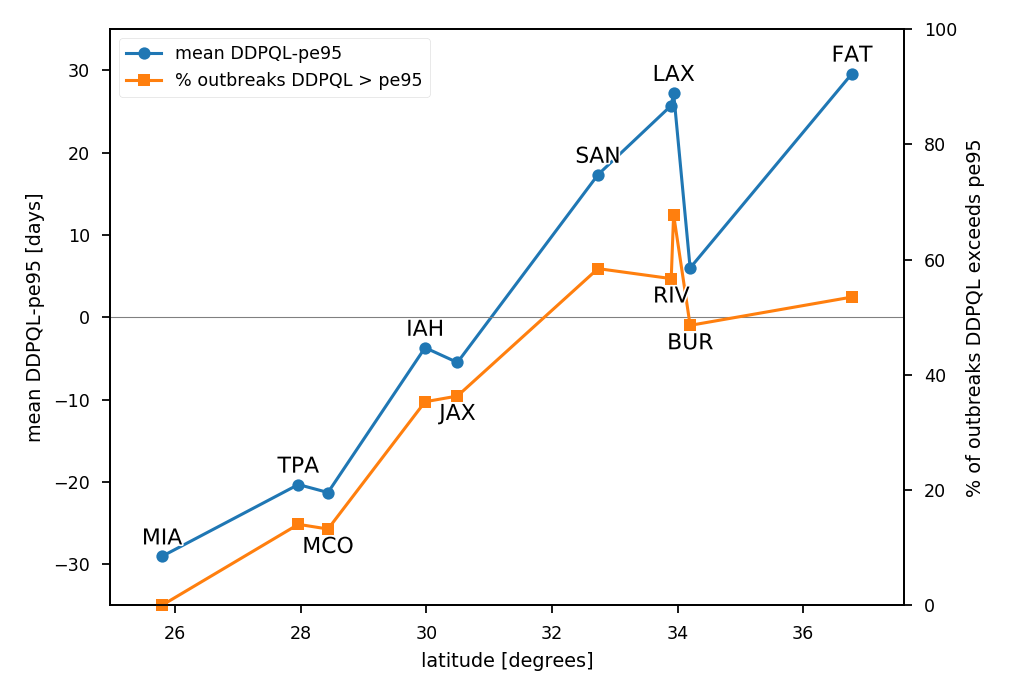

In [24]:
tmp = df.iloc[1:] # omit SFO which is element 0

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
ax.margins(0.075,0.075)
ax2.margins(0.075,0.075)

ax.plot(tmp['lat'], tmp['mean'], marker='o', color='C0', 
        label='mean DDPQL-pe95', clip_on=False)
ax2.plot(tmp['lat'], tmp['%days>0'], marker='s', color='C1',
         label='% outbreaks DDPQL > pe95', clip_on=False)

ax.set_ylim([-35,35])
ax2.set_ylim([0,100])

ax.axhline(0, lw=.5, color='gray')

# annotating points with site names... a bit complicated to make nice
trans_offset_up = mpl.transforms.offset_copy(ax.transData, fig=fig, x=0, y=.05)
trans_offset_down = mpl.transforms.offset_copy(ax.transData, fig=fig, x=0, y=-.05)
for i,rs in enumerate(tmp.index):
    ym = ax.transData.transform((0,tmp.loc[rs]['mean']))[1]
    yd = ax2.transData.transform((0,tmp.loc[rs]['%days>0']))[1]
    if i != len(tmp.index)-1 and i%2 == 1:
        if ym < yd:
            a = ax2.text(tmp.loc[rs]['lat'], tmp.loc[rs]['mean'], rs[1:],
                    ha='center', va='top', transform=trans_offset_down)
        else:
            y = ax.transData.inverted().transform((0,yd))[1]
            a = ax2.text(tmp.loc[rs]['lat'], y, rs[1:],
                    ha='center', va='top', transform=trans_offset_down)
    else:
        if ym > yd:
            a = ax2.text(tmp.loc[rs]['lat'], tmp.loc[rs]['mean'], rs[1:],
                    ha='center', va='bottom', transform=trans_offset_up)
        else:
            y = ax.transData.inverted().transform((0,yd))[1]
            a = ax2.text(tmp.loc[rs]['lat'], y, rs[1:],
                    ha='center', va='bottom', transform=trans_offset_up)
    a.set_path_effects([patheffects.Stroke(linewidth=1.5, foreground='white'),
                        patheffects.Normal()])

ax.set_ylabel('mean DDPQL-pe95 [days]')
ax2.set_ylabel('% of outbreaks DDPQL exceeds pe95')
ax.set_xlabel('latitude [degrees]')

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
leg = ax.legend(h1+h2, l1+l2)

fig.tight_layout()

<IPython.core.display.Javascript object>


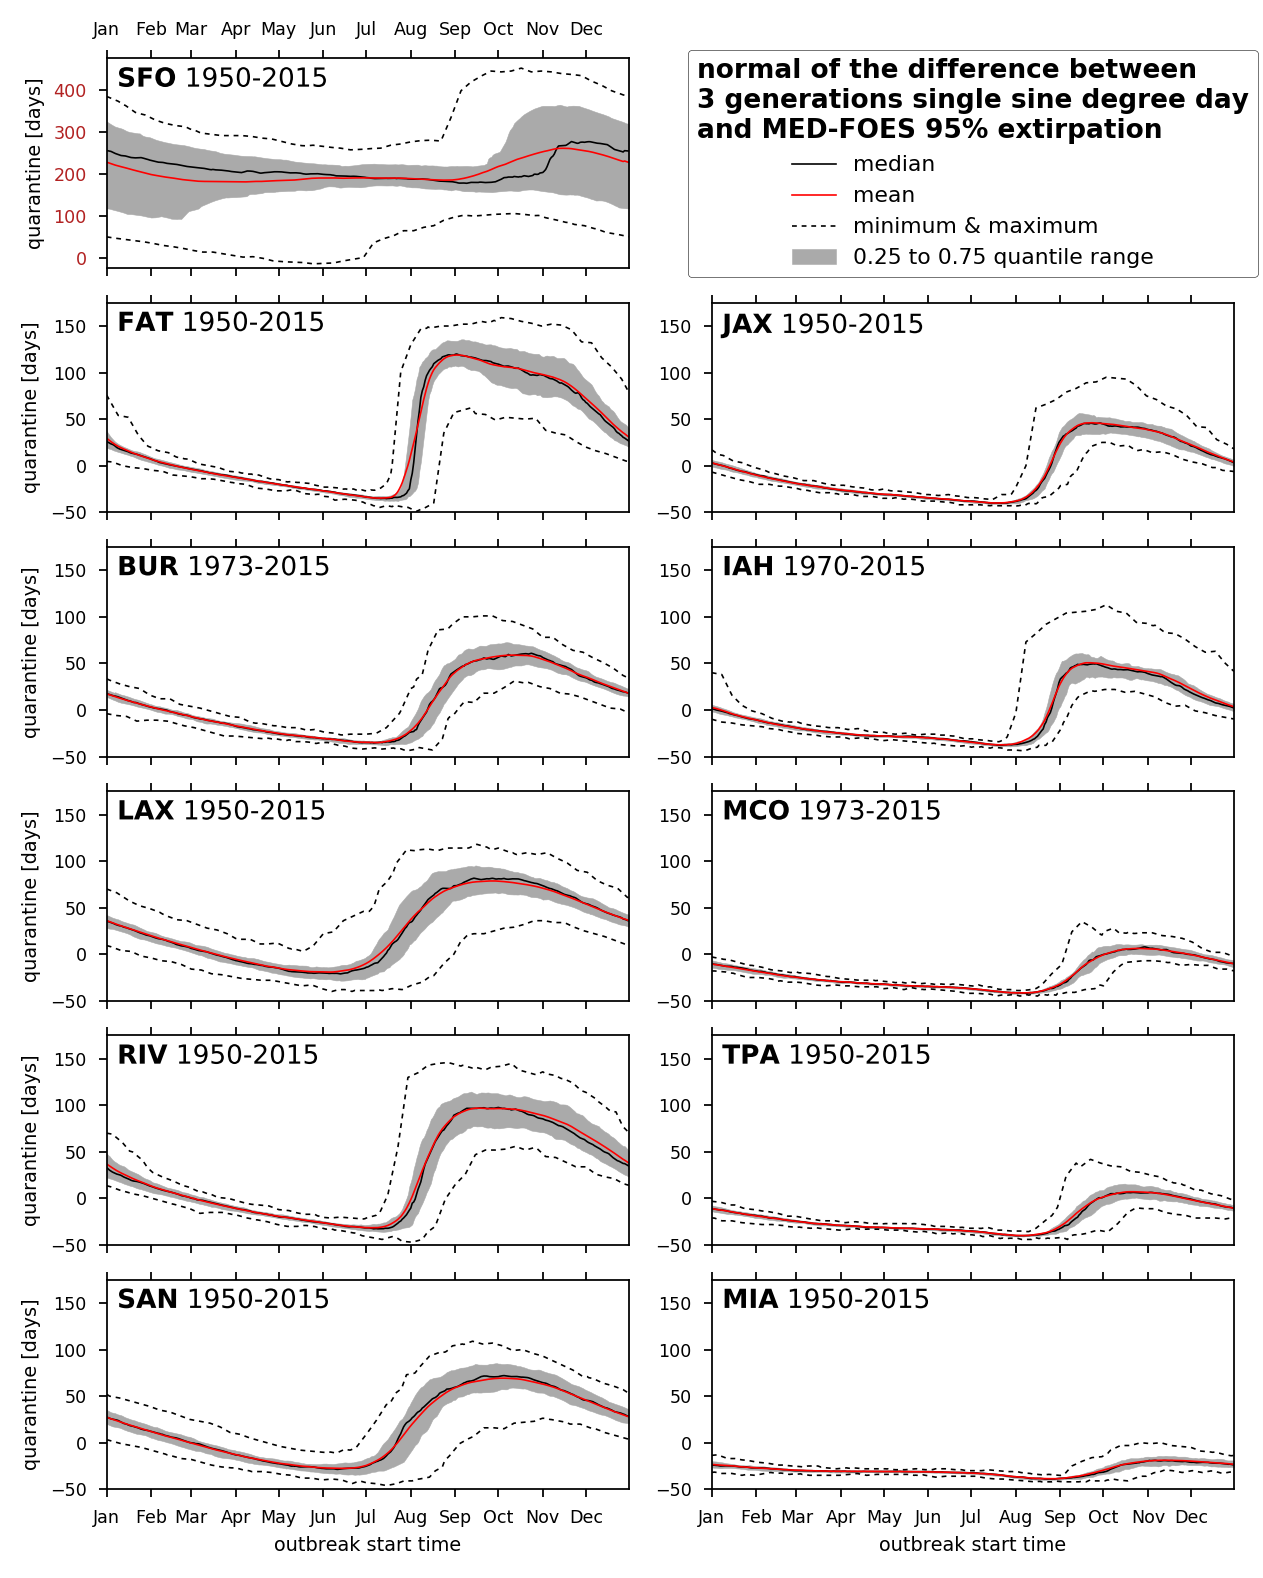

KSFO 1950-01-01 2016-01-01
KFAT 1950-01-01 2016-01-01
KBUR 1973-01-01 2016-01-01
KLAX 1950-01-01 2016-01-01
KRIV 1950-01-01 2016-01-01
KSAN 1950-01-01 2016-01-01
KJAX 1950-01-01 2016-01-01
KIAH 1970-01-01 2016-01-01
KMCO 1973-01-01 2016-01-01
KTPA 1950-01-01 2016-01-01
KMIA 1950-01-01 2016-01-01


In [25]:
fig = plot_all_supernorm('bmdd-pe95',
                         #datafunc=lambda x: x['dur_days'],
                         ylim=[-50,175],
                         ylim_dict={0:(-25,475)},
                         xlabel='outbreak start time',
                         ylabel='quarantine [days]',
                         legend_title='normal of the difference between\n'+
                         '3 generations single sine degree day\n'+
                         'and MED-FOES 95% extirpation',
                        )
fig.savefig(os.path.join(FIGDIR, 'fig_all_BMDD-pe95_supernorm.pdf'))